# H2CO molecute - optimize

This is a light example of how to optimize the molecular potential.
For more sophistecated optimization, refer `docs/notebook/_h2co_opt.py`.

![](assets/trace.svg)

## Environment

In [1]:
# | echo: false
import platform
import sys

import pompon

print(sys.version)
print(f"pompon version = {pompon.__version__}")
print(platform.platform())

3.12.2 (main, Feb  6 2024, 20:19:44) [Clang 15.0.0 (clang-1500.1.0.2.5)]
pompon version = 0.0.9
macOS-14.4.1-arm64-arm-64bit


## Import modules

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Set your favorite.
plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams.update(
    {
        "image.cmap": "jet",
    }
)

## Load data

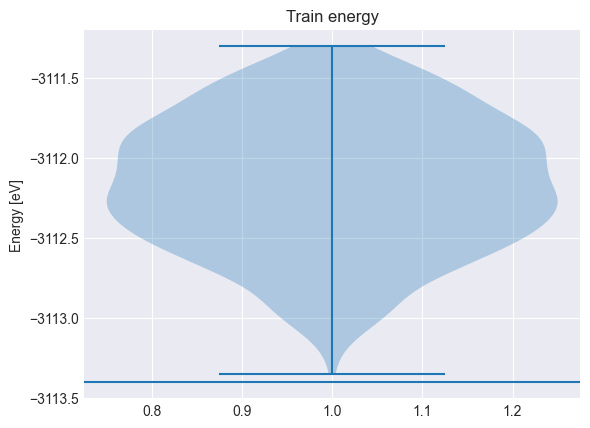

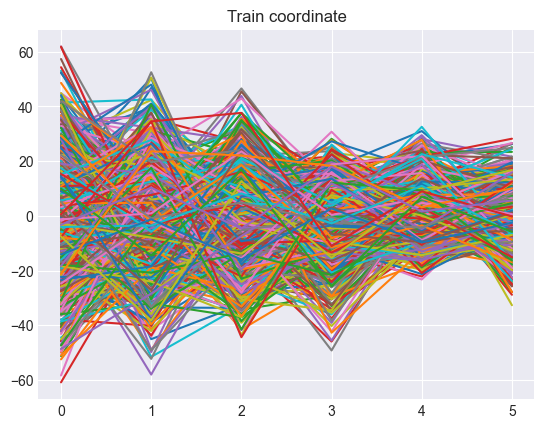

In [3]:
x_train = np.load("data/x_train.npy")
x_test = np.load("data/x_test.npy")
x_valid = np.load("data/x_validation.npy")

y_train = np.load("data/y_train.npy")
y_test = np.load("data/y_test.npy")
y_valid = np.load("data/y_validation.npy")

f_train = np.load("data/f_train.npy")
f_test = np.load("data/f_test.npy")
f_valid = np.load("data/f_validation.npy")

y_shift = -3112.1604302407663  # eV (mean)
y_min = -3113.4044750979383  # eV (eq. position)


plt.title("Train energy")
plt.violinplot(y_train + y_shift)
plt.axhline(y_min)
plt.ylabel("Energy [eV]")
plt.plot()
plt.show()

plt.title("Train coordinate")
plt.plot(np.arange(6), x_train.T)
plt.show()

In [4]:
x_scale = x_train.std()
y_scale = y_train.std()

x_train /= x_scale
x_test /= x_scale
x_valid /= x_scale
y_train /= y_scale
y_test /= y_scale
y_valid /= y_scale
f_train /= y_scale / x_scale
f_test /= y_scale / x_scale
f_valid /= y_scale / x_scale

## Consturct a model

MPO is encoded from sum of products functions.
We start from SOP training, and then convert it to MPO.

In [5]:
pompon.OneBody?

Init signature:
pompon.OneBody(
    input_size: int,
    hidden_size: int,
    basis_size: int,
    output_size: int = 1,
    w_scale: float = 1.0,
    b_scale: float = 1.0,
    w_dist: str = 'uniform',
    b_dist: str = 'linspace',
    x0: jax.Array | None = None,
    activation: str = 'moderate+silu',
    key: jax.Array | None = None,
    X_out: numpy.ndarray | None = None,
    fix_bias: bool = False,
)
Docstring:     
Function given by sum of one-body functions

$$
   f(q_1, q_2, \ldots, q_f) =
   \sum_{p=1}^{f} \sum_{\rho_p} W_{\rho_p}^{(p)}
   \phi_{\rho_p}(w_{\rho_p}^{(p)} q_p+b_{\rho_p}^{(p)})
$$
File:           ~/GitHub/Pompon/pompon/sop.py
Type:           ABCMeta
Subclasses:     

## One-body regression

$$
f(q_1, q_2, \ldots, q_f) =
   \sum_{p=1}^{f} \sum_{\rho_p} W_{\rho_p}^{(p)} \phi_{\rho_p}(w_{\rho_p}^{(p)} (q_p-q^{\mathrm{ref}}_{\rho_p})+b_{\rho_p}^{(p)})
$$
$$
\mathbf{q}-\mathbf{q}^{\mathbf{ref}} = (\mathbf{x} - \mathbf{x}^{\mathrm{ref}}) U
$$

In [6]:
n = 6
f = 6
N = 21

onebody = pompon.OneBody(
    input_size=n,
    hidden_size=f,
    basis_size=N,
    activation="moderate+silu",
    b_scale=0.0,
    b_dist="uniform",
    w_scale=1.0,
    fix_bias=False,
    x0=x_train[: N - 1],
)

## Visualize initial one-body function

In [7]:
def show_onebody(model):
    f = model.hidden_size
    fig, axs = plt.subplots(1, f, figsize=(4 * f, 4))

    for i in range(f):
        x = np.linspace(np.min(x_train[:, i]), np.max(x_train[:, i]), 100)
        _x = np.zeros((100, 6))
        _x[:, i] = x
        y = model.forward(_x)[:, 0]
        axs[i].set_title(f"{i}-site")
        axs[i].set_xlabel(f"$x_{i}$")
        axs[i].plot(x, y)
    plt.show()

In [8]:
def show_basis(model):
    f = model.hidden_size
    fig, axs = plt.subplots(1, f, figsize=(4 * f, 4))
    q = model.coordinator.forward(x_train)
    q0 = model.q0
    for i in range(f):
        _q = np.linspace(np.min(q[:, i]), np.max(q[:, i]), 100)
        phi = model.basis[i].forward(_q, q0[:, i])
        axs[i].set_title(f"{i}-site")
        axs[i].set_xlabel(f"$Q_{i}$")
        axs[i].plot(_q, phi)
    plt.show()

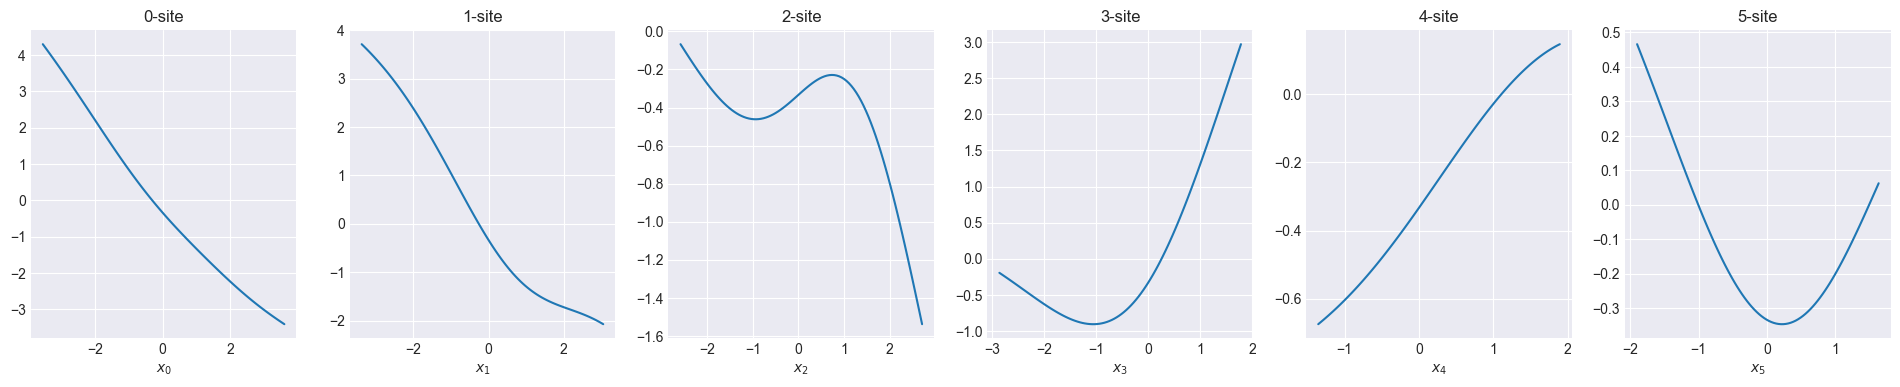

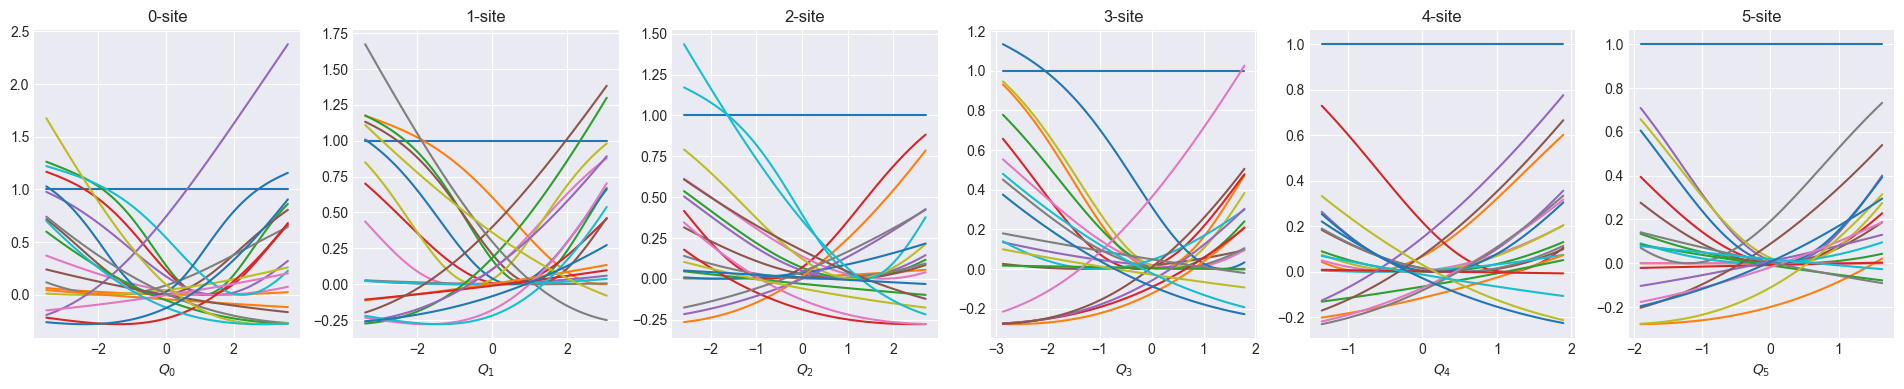

In [9]:
show_onebody(onebody)
show_basis(onebody)

## Optimize one-body

2024-10-16 10:39:44 - INFO:pompon.pompon.model - Model is exported to data/model_initial.h5


  0%|          | 0/500 [00:00<?, ?it/s]

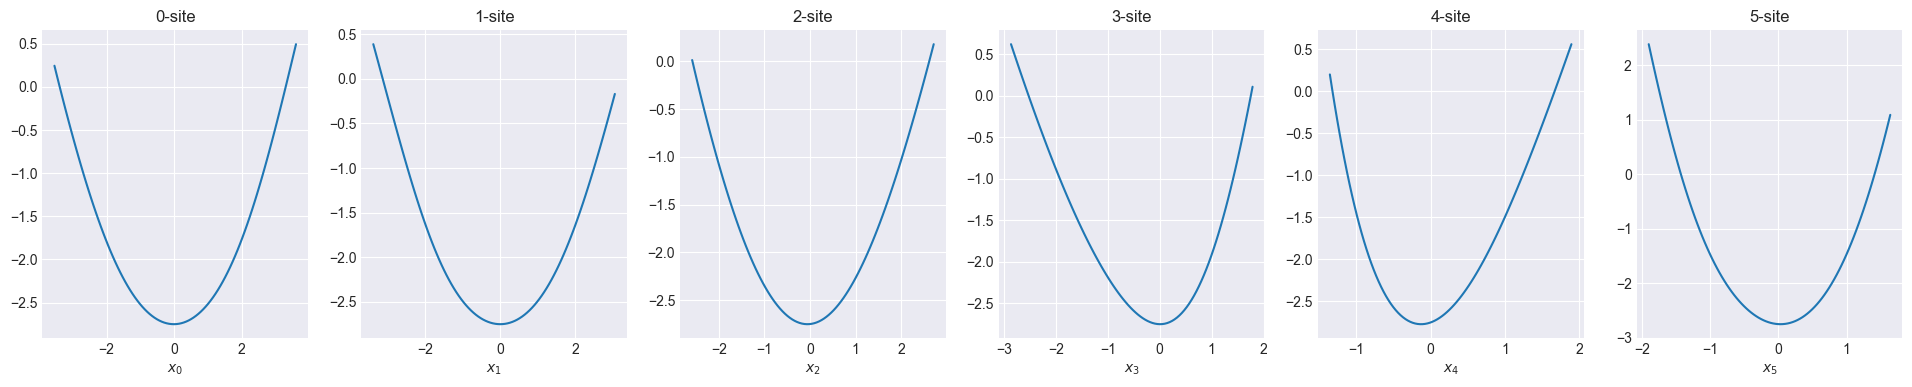

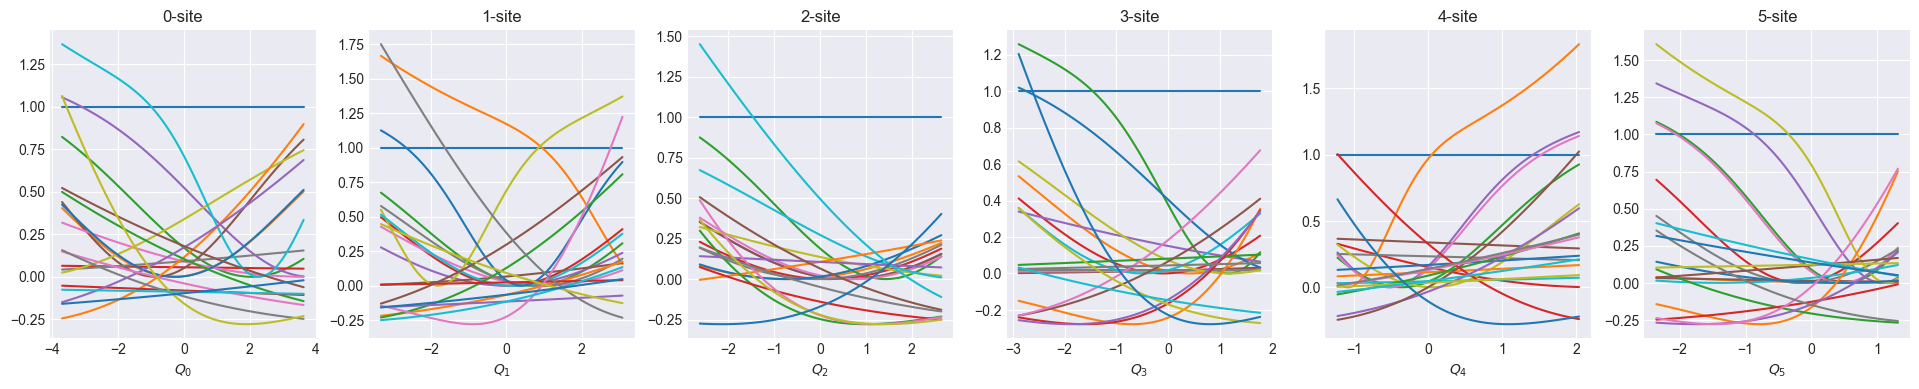

In [10]:
from pompon.optimizer import Adam

optimizer = Adam(lr=1.0e-02).setup(
    model=onebody,
    x_train=x_train,
    y_train=y_train,
    f_train=f_train,
    batch_size=625,
    x_test=x_test,
    y_test=y_test,
    outdir="data",
)
trace = optimizer.optimize(epochs=500, epoch_per_log=500)
show_onebody(onebody)
show_basis(onebody)

In [11]:
def plot_trace(trace):
    plt.plot(
        trace["epoch"], np.sqrt(trace["mse_train"]) * y_scale, label="train"
    )
    plt.plot(trace["epoch"], np.sqrt(trace["mse_test"]) * y_scale, label="test")
    plt.xticks(np.arange(0, trace["epoch"][-1], 4000), rotation=45)
    plt.xlabel("epochs")
    plt.ylabel("RMSE Energy [eV]")
    plt.yscale("log")
    plt.legend()
    plt.show()

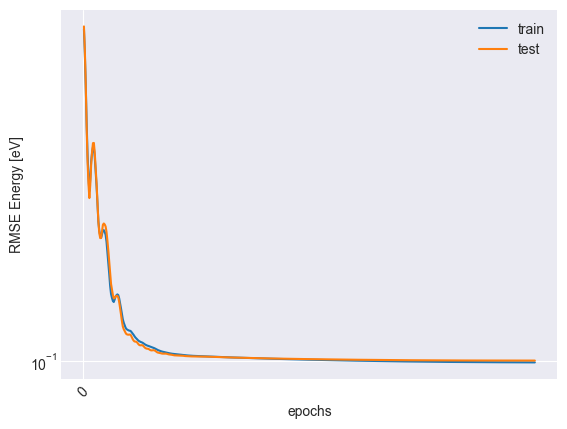

In [12]:
plot_trace(trace)

In [13]:
onebody.export_h5("data/onebody.h5")
onebody = pompon.OneBody.import_h5("data/onebody.h5")

2024-10-16 10:39:50 - INFO:pompon.pompon.model - Model is exported to data/onebody.h5
2024-10-16 10:39:50 - INFO:pompon.pompon.model - Model is imported from data/onebody.h5


Sum of one-body function can fit in 100 meV order.

## Visualize coordinator after one-body optimization

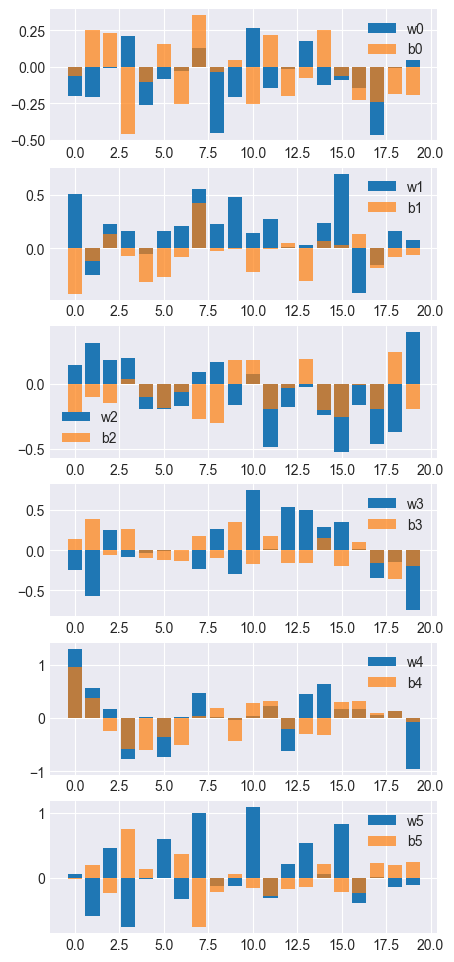

In [14]:
onebody.basis.plot_data()

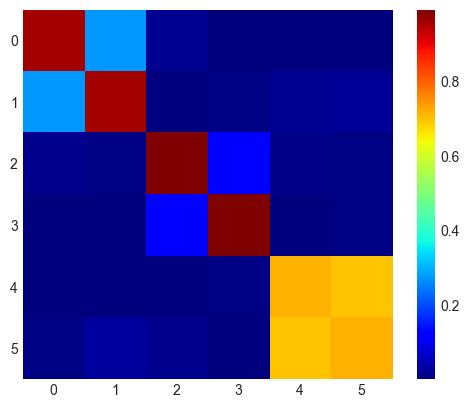

In [15]:
plt.imshow(np.abs(onebody.coordinator.U.data))
plt.grid()
plt.colorbar()
plt.show()

## Use one-body function as initial NNMPO

$$
y = W_0 + W_1\phi^{(1)} + \cdots W_f\phi^{(f)}
$$
$$
\to
\begin{bmatrix}
1 & W_0 + W_1\phi^{(1)} \\
\end{bmatrix}
\begin{bmatrix}
1 & W_2\phi^{(2)} \\
0 & 1 \\
\end{bmatrix}
\begin{bmatrix}
1 & W_3\phi^{(3)} \\
0 & 1 \\
\end{bmatrix}
\cdots
\begin{bmatrix}
 W_3\phi^{(f)} \\
 1 \\
\end{bmatrix}
$$

In [16]:
nnmpo = onebody.to_nnmpo()

2024-10-16 10:39:51 - INFO:pompon.pompon.sop - OneBody function is converted to NNMPO


In [17]:
from pompon.optimizer import Adam, Sweeper

optimizer = Adam(lr=1.0e-03).setup(
    model=nnmpo,  # <- changed!!
    x_train=x_train,
    y_train=y_train,
    f_train=f_train,
    batch_size=125,
    x_test=x_valid,
    y_test=y_valid,
    outdir="data",
)

sweeper = Sweeper(optimizer)

2024-10-16 10:39:51 - INFO:pompon.pompon.model - Model is exported to data/model_initial.h5


0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

2024-10-16 10:40:02 - INFO:pompon.pompon.model - Model is exported to data/nnmpo_step_0_rmse_7.492e-02.h5


0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

2024-10-16 10:40:16 - INFO:pompon.pompon.model - Model is exported to data/nnmpo_step_1_rmse_2.839e-02.h5


0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

2024-10-16 10:40:30 - INFO:pompon.pompon.model - Model is exported to data/nnmpo_step_2_rmse_2.070e-02.h5


0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

2024-10-16 10:40:43 - INFO:pompon.pompon.model - Model is exported to data/nnmpo_step_3_rmse_3.494e-02.h5


0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

2024-10-16 10:40:56 - INFO:pompon.pompon.model - Model is exported to data/nnmpo_step_4_rmse_1.418e-02.h5


0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

2024-10-16 10:41:23 - INFO:pompon.pompon.model - Model is exported to data/nnmpo_step_5_rmse_7.052e-03.h5


0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

2024-10-16 10:41:41 - INFO:pompon.pompon.model - Model is exported to data/nnmpo_step_6_rmse_5.909e-03.h5


0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

2024-10-16 10:41:59 - INFO:pompon.pompon.model - Model is exported to data/nnmpo_step_7_rmse_5.411e-03.h5


0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

2024-10-16 10:42:17 - INFO:pompon.pompon.model - Model is exported to data/nnmpo_step_8_rmse_5.059e-03.h5


0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

2024-10-16 10:42:35 - INFO:pompon.pompon.model - Model is exported to data/nnmpo_step_9_rmse_4.715e-03.h5


0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

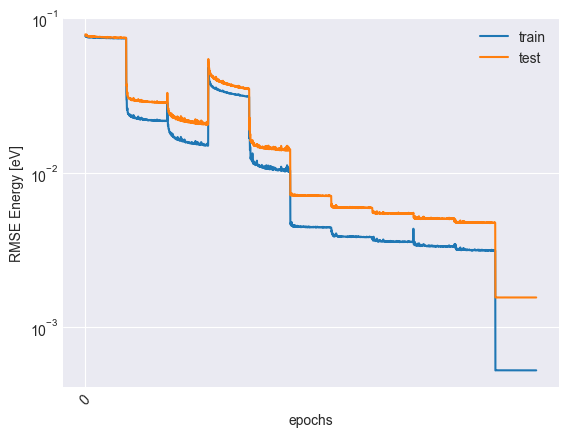

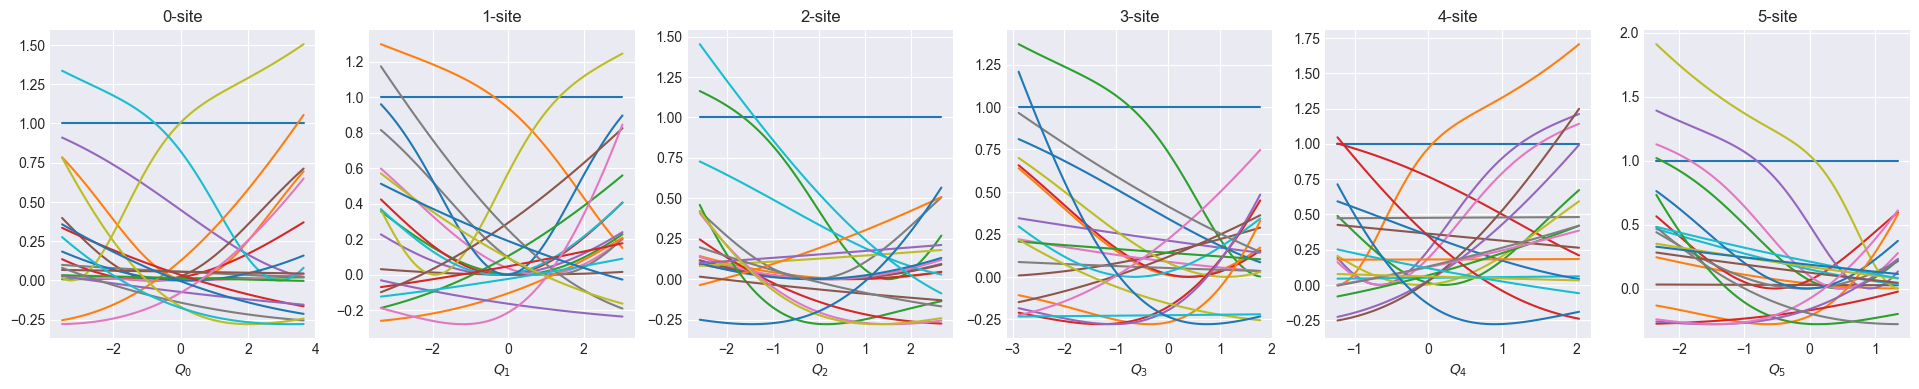

In [18]:
import optax

for i in range(5):
    optimizer.lr = 1.0e-03
    solver = optax.adam(1.0e-04)
    sweeper.sweep(
        nsweeps=3,
        opt_tol=1.0e-10,
        opt_maxiter=100,
        opt_batchsize=625,
        cutoff=1.0e-01,
        optax_solver=solver,
        onedot=(i == 0),  # <- First step should be onedot.
        auto_onedot=False,  # <- Automatically switch to onedot if the bond dimension reaches maxdim.
        maxdim=14,
    )
    trace = optimizer.optimize(epochs=200, epoch_per_log=200)
    nnmpo.export_h5(
        f'data/nnmpo_step_{i}_rmse_{np.sqrt(trace["mse_test"][-1]) * y_scale:.3e}.h5'
    )

for i in range(5, 10):
    optimizer.lr = 1.0e-04  # <- Lower learning rate.
    solver = optax.adam(1.0e-05)
    sweeper.sweep(
        nsweeps=3,
        opt_tol=1.0e-10,
        opt_maxiter=500,
        opt_batchsize=625,
        cutoff=1.0e-02,
        optax_solver=solver,
        onedot=(i == 0),  # <- First step should be onedot.
        auto_onedot=True,  # <- Automatically switch to onedot if the bond dimension reaches maxdim.
        maxdim=14,
    )
    trace = optimizer.optimize(epochs=200, epoch_per_log=200)
    nnmpo.export_h5(
        f'data/nnmpo_step_{i}_rmse_{np.sqrt(trace["mse_test"][-1]) * y_scale:.3e}.h5'
    )

# Conjugate gradient optimization
sweeper.sweep(
    nsweeps=10,
    opt_tol=1.0e-08,
    opt_maxiter=2000,
    opt_batchsize=625,
    # optax_solver=solver,
    use_CG=True,  # <-- !!!
    onedot=True,
    maxdim=14,
)
optimizer.lr = 1.0e-07
trace = optimizer.optimize(epochs=200, epoch_per_log=200)

plot_trace(trace)
show_basis(nnmpo)

In [19]:
nnmpo.rescale(x_scale, y_scale)
nnmpo.export_h5(
    f'data/nnmpo_final_rmse_{np.sqrt(trace["mse_test"][-1]) * y_scale:.3e}.h5'
)

2024-10-16 10:44:16 - INFO:pompon.pompon.model - Model is exported to data/nnmpo_final_rmse_1.550e-03.h5


In [20]:
trace

epoch,mse_train,mse_test,mse_train_f,tt_norm,tt_ranks
i64,f64,f64,f64,f64,list[i64]
1,0.033321,0.034835,0.259389,-14.813811,"[2, 2, … 2]"
2,0.033062,0.034307,0.259242,-14.813811,"[2, 2, … 2]"
3,0.033042,0.033916,0.256926,-14.813811,"[2, 2, … 2]"
4,0.032263,0.033084,0.255528,-14.813811,"[2, 2, … 2]"
5,0.033542,0.034455,0.254564,-14.813811,"[2, 2, … 2]"
…,…,…,…,…,…
2196,0.000002,0.000014,0.00001,-220.626693,"[8, 14, … 9]"
2197,0.000002,0.000013,0.00001,-220.626693,"[8, 14, … 9]"
2198,0.000002,0.000013,0.00001,-220.626693,"[8, 14, … 9]"


## Visualize the optimization traces

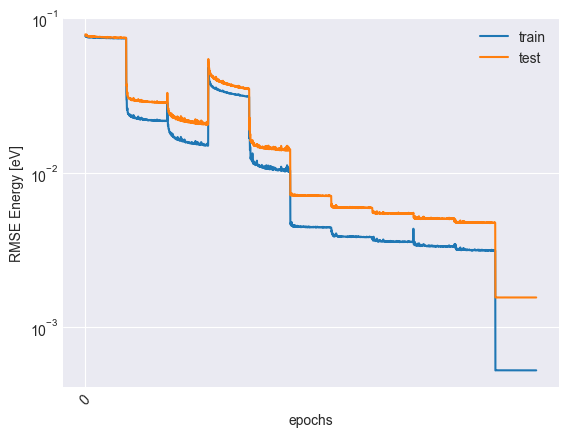

In [27]:
# | code-fold: true
# | fig-cap: "MSE of training and test data"
plt.plot(trace["epoch"], np.sqrt(trace["mse_train"]) * y_scale, label="train")
plt.plot(trace["epoch"], np.sqrt(trace["mse_test"]) * y_scale, label="test")
plt.xticks(np.arange(0, trace["epoch"][-1], 4000), rotation=45)
plt.xlabel("epochs")
plt.ylabel("RMSE Energy [eV]")
plt.yscale("log")
plt.legend()
plt.savefig('assets/trace.svg')
plt.show()

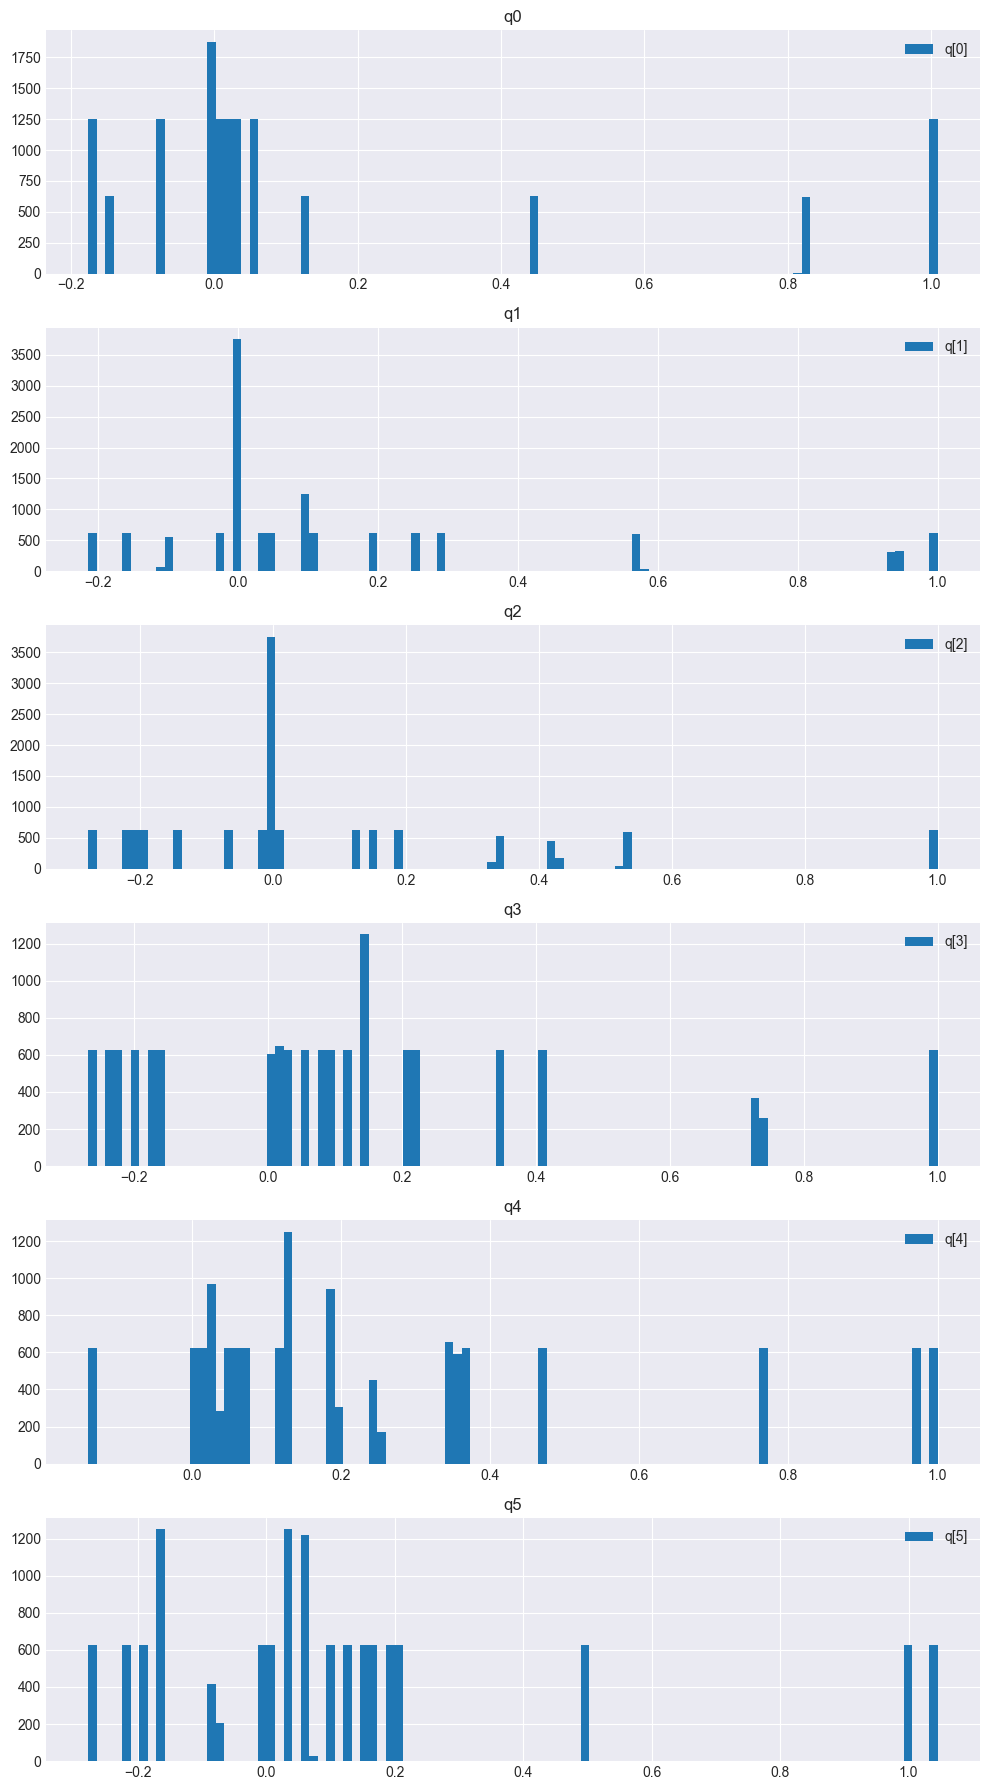

In [22]:
nnmpo.plot_basis(x_train / x_scale)

In [23]:
for param in nnmpo.params():
    print(param)
    if param.name.startswith("b"):
        print(param.data)

Parameter(w1, shape=(20,))
Parameter(b1, shape=(20,))
[-0.39287908 -0.13464318  0.14050318 -0.07814877 -0.03572304 -0.37963561
 -0.0855011   0.55868097 -0.01750081  0.23813855 -0.27342234  0.04030169
  0.12940236 -0.32228352  0.09547939 -0.01471205  0.06512873 -0.2840365
  0.04007023  0.20726764]
Parameter(b3, shape=(20,))
[ 0.15595645  0.78521664 -0.22730115  0.3919457  -0.26728326 -0.24770266
 -0.21508083  0.17693537 -0.05250274  0.41195362 -0.29535957  0.21481374
 -0.17795398 -0.26547028  0.2415685  -0.15915255  0.38545226 -0.17031766
 -0.66347873 -0.22850493]
Parameter(w3, shape=(20,))
Parameter(w0, shape=(20,))
Parameter(b0, shape=(20,))
[-0.09522305  0.11708057  0.29824885 -0.48003036 -0.09094859  0.09054434
 -0.27302538  0.45346682  0.25239392  0.0707163  -0.31713018  0.03327424
 -0.12000518 -0.021749    0.10488636 -0.18124672 -0.33535119 -0.46569359
 -0.21225473 -0.10930101]
Parameter(b2, shape=(20,))
[-0.32414808 -0.17914898 -0.11512402  0.07283107 -0.11565191 -0.21038414
 -0.

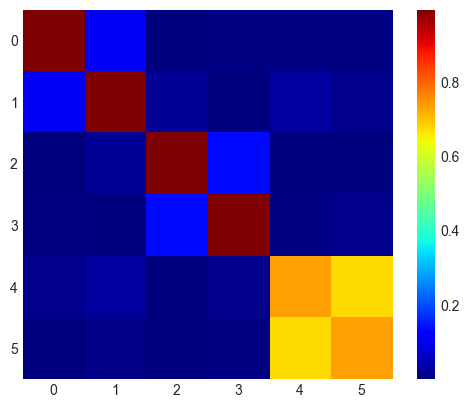

In [24]:
plt.imshow(np.abs(nnmpo.coordinator.U.data))
plt.grid()
plt.colorbar()
plt.show()

In [25]:
nnmpo = pompon.NNMPO.import_h5(
    f'data/nnmpo_final_rmse_{np.sqrt(trace["mse_test"][-1]) * y_scale:.3e}.h5'
)
y_pred = nnmpo.forward(x_test * x_scale)

2024-10-16 10:44:17 - INFO:pompon.pompon.model - Model is imported from data/nnmpo_final_rmse_1.550e-03.h5


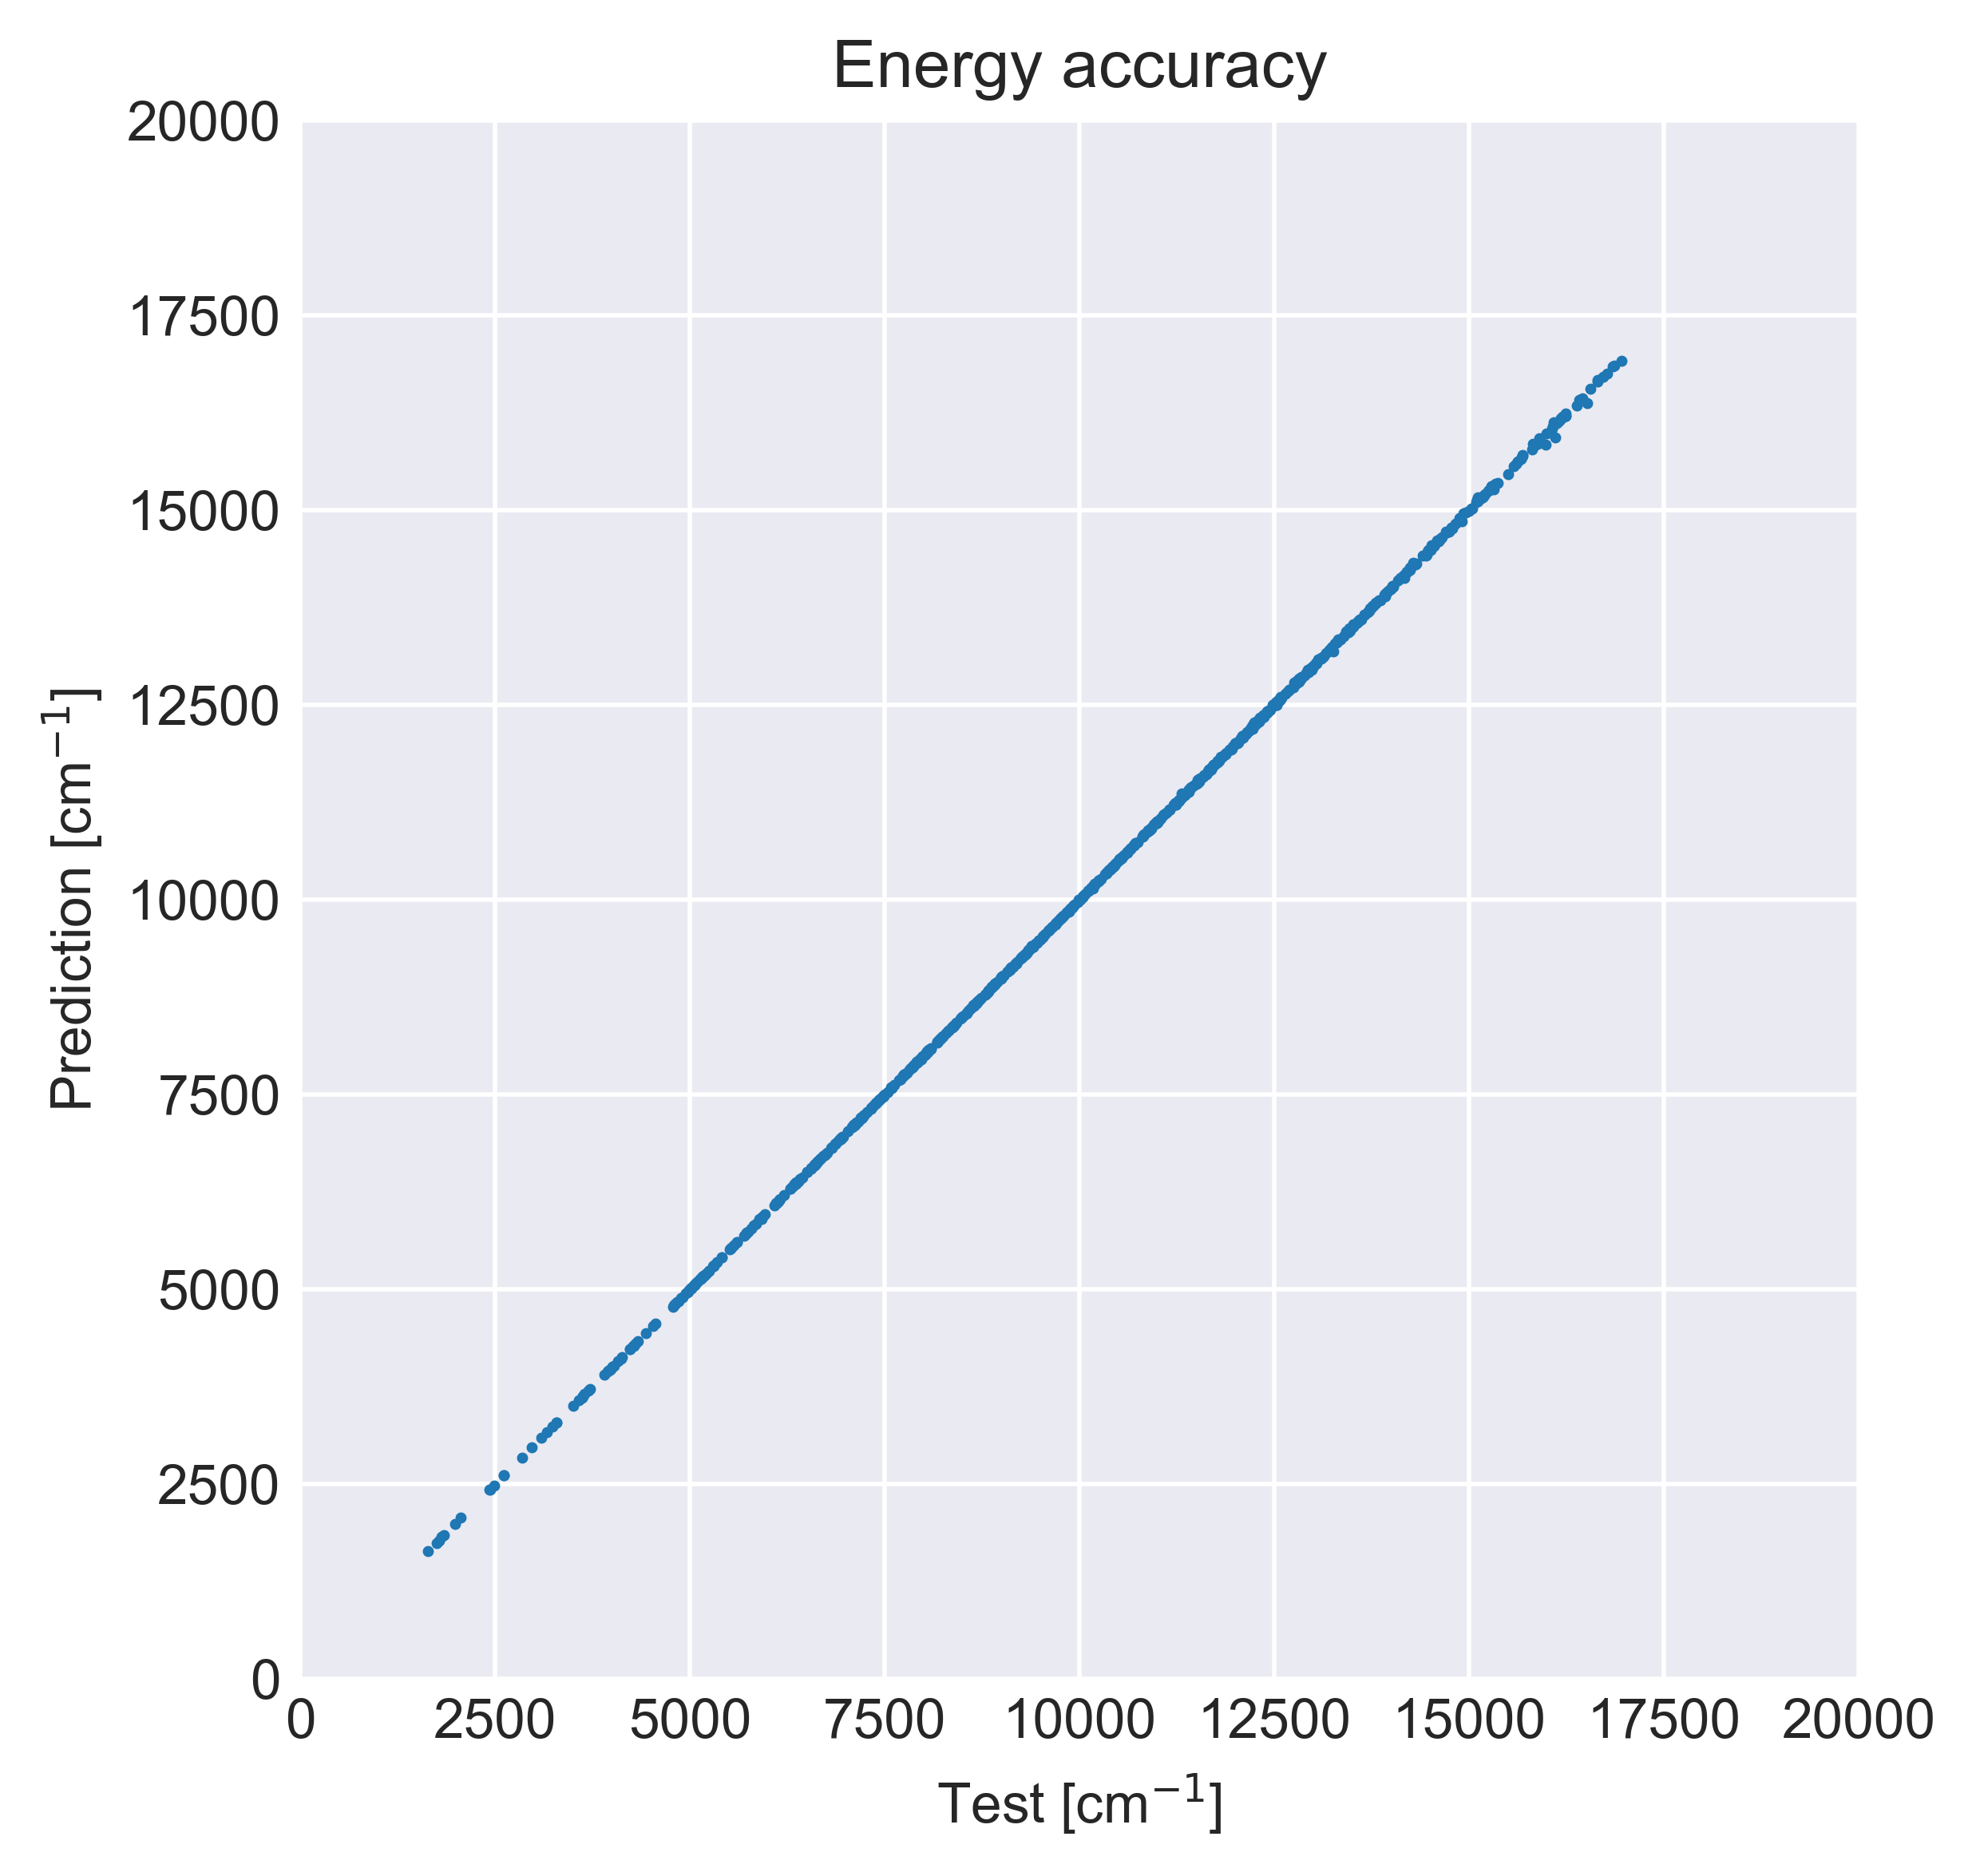

In [26]:
fig, ax = plt.subplots(dpi=500)

ax.scatter(
    (y_test * y_scale + y_shift - y_min) * 8.065544e3,
    (y_pred + y_shift - y_min) * 8.065544e3,
    s=1,
)
plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel("Test [cm$^{-1}$]")
plt.ylabel("Prediction [cm$^{-1}$]")
plt.xlim(0, 20000)
plt.ylim(0, 20000)
plt.title("Energy accuracy")
plt.tight_layout()
plt.show()